# Knowledge Distillation



Knowledge distillation is a technique that enables knowledge transfer from large, computationally expensive models to smaller ones without losing validity. This allows for deployment on less powerful hardware, making evaluation faster and more efficient.

In this  we will run a number of experiments focused at improving the accuracy of a lightweight neural network, using a more powerful network as a teacher.

## Prerequisites

1 GPU, 4GB of memory

PyTorch v2.0 or later

CIFAR-10 dataset (downloaded by the script and saved in a directory called /data)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
# Check if GPU is available, and if not, use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading CIFAR-10

CIFAR-10 is a popular image dataset with ten classes. Our objective is to predict one of the following classes for each input image.

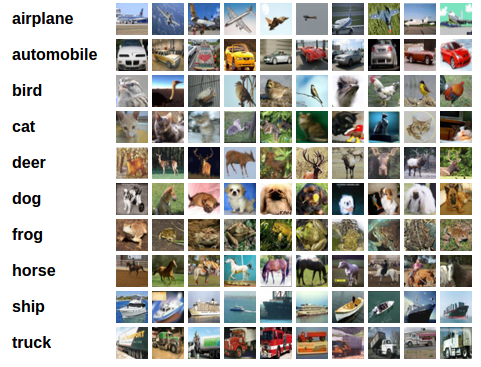

The input images are RGB, so they have 3 channels and are 32x32 pixels. Basically, each image is described by 3 x 32 x 32 = 3072 numbers ranging from 0 to 255. A common practice in neural networks is to normalize the input, which is done for multiple reasons, including avoiding saturation in commonly used activation functions and increasing numerical stability. Our normalization process consists of subtracting the mean and dividing by the standard deviation along each channel. The tensors “mean=[0.485, 0.456, 0.406]” and “std=[0.229, 0.224, 0.225]” were already computed, and they represent the mean and standard deviation of each channel in the predefined subset of CIFAR-10 intended to be the training set

In [3]:
# # Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#Loading CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=1)

## Defining model classes and utility functions

We use two different architectures, keeping the number of filters fixed across our experiments to ensure fair comparisons. Both architectures are Convolutional Neural Networks (CNNs) with a different number of convolutional layers that serve as feature extractors, followed by a classifier with 10 classes. The number of filters and neurons is smaller for the students.

In [5]:
# Deep Neural Network class to be used as a teacher

class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0,1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifer = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifer(x)
        return x

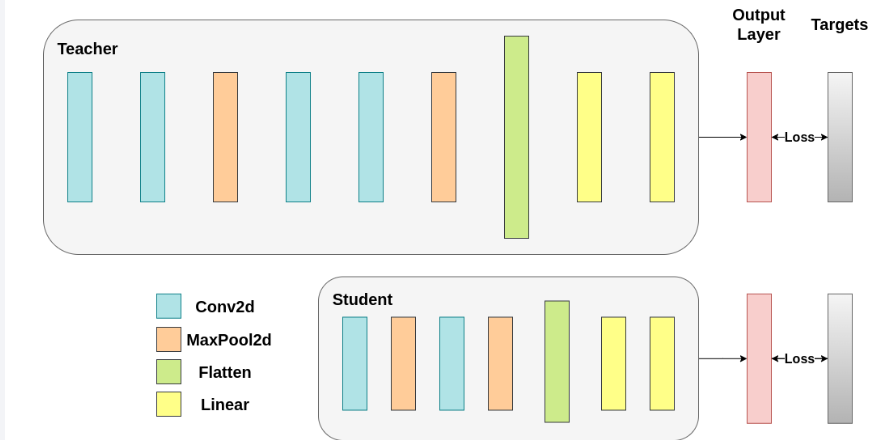

Train both networks with Cross-Entropy. The student will be used as a baseline:

In [15]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels )
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()

        print(f'Epoch: {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

def test(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()

    accuracy = 100*correct/total
    print(f'Test Accuracy: {accuracy}%')
    return accuracy

For reproducibility, we need to set the torch manual seed. We train networks using different methods, so to compare them fairly, it makes sense to initialize the networks with the same weights. Start by training the teacher network using cross-entropy

In [16]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, epochs = 10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

Epoch: 1/10, Loss: 1.3341022597249512
Epoch: 2/10, Loss: 0.8610368956385366
Epoch: 3/10, Loss: 0.6584984210446058
Epoch: 4/10, Loss: 0.5162132136961993
Epoch: 5/10, Loss: 0.3794614348722541
Epoch: 6/10, Loss: 0.2690276647810741
Epoch: 7/10, Loss: 0.1814469510922804
Epoch: 8/10, Loss: 0.13387061959451727
Epoch: 9/10, Loss: 0.10699528553868498
Epoch: 10/10, Loss: 0.09283963842150729
Test Accuracy: 74.12%


We instantiate one more lightweight network model to compare their performances. Back propagation is sensitive to weight initialization, so we need to make sure these two networks have the exact same initialization.

In [17]:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

To ensure we have created a copy of the first network, we inspect the norm of its first layer. If it matches, then we are safe to conclude that the networks are indeed the same.

In [18]:
# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


In [19]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,186,986
LightNN parameters: 267,738


Train and test the lightweight network with cross entropy loss:

In [20]:
train(nn_light, train_loader, epochs = 10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

Epoch: 1/10, Loss: 1.470192398256658
Epoch: 2/10, Loss: 1.1568061012746123
Epoch: 3/10, Loss: 1.0240015773212208
Epoch: 4/10, Loss: 0.9237757056875302
Epoch: 5/10, Loss: 0.850199384762503
Epoch: 6/10, Loss: 0.7850499642474572
Epoch: 7/10, Loss: 0.7195839212678582
Epoch: 8/10, Loss: 0.6639605779629534
Epoch: 9/10, Loss: 0.6144038321417006
Epoch: 10/10, Loss: 0.5609197134099653
Test Accuracy: 70.35%


Based on test accuracy, we can now compare the deeper network that is to be used as a teacher with the lightweight network that is our supposed student. So far, our student has not intervened with the teacher, therefore this performance is achieved by the student itself. The metrics so far can be seen as:

In [21]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 74.12%
Student accuracy: 70.35%


## Knowledge distillation run

Now let’s try to improve the test accuracy of the student network by incorporating the teacher. Knowledge distillation is a straightforward technique to achieve this, based on the fact that both networks output a probability distribution over our classes. Therefore, the two networks share the same number of output neurons. The method works by incorporating an additional loss into the traditional cross entropy loss, which is based on the softmax output of the teacher network. The assumption is that the output activations of a properly trained teacher network carry additional information that can be leveraged by a student network during training. The original work suggests that utilizing ratios of smaller probabilities in the soft targets can help achieve the underlying objective of deep neural networks, which is to create a similarity structure over the data where similar objects are mapped closer together. For example, in CIFAR-10, a truck could be mistaken for an automobile or airplane, if its wheels are present, but it is less likely to be mistaken for a dog. Therefore, it makes sense to assume that valuable information resides not only in the top prediction of a properly trained model but in the entire output distribution. However, cross entropy alone does not sufficiently exploit this information as the activations for non-predicted classes tend to be so small that propagated gradients do not meaningfully change the weights to construct this desirable vector space.

As we continue defining our first helper function that introduces a teacher-student dynamic, we need to include a few extra parameters:

- `T`: Temperature controls the smoothness of the output distributions. Larger T leads to smoother distributions, thus smaller probabilities get a larger boost.

- `soft_target_loss_weight`: A weight assigned to the extra objective we’re about to include.

- `ce_loss_weight`: A weight assigned to cross-entropy. Tuning these weights pushes the network towards optimizing for either objective.

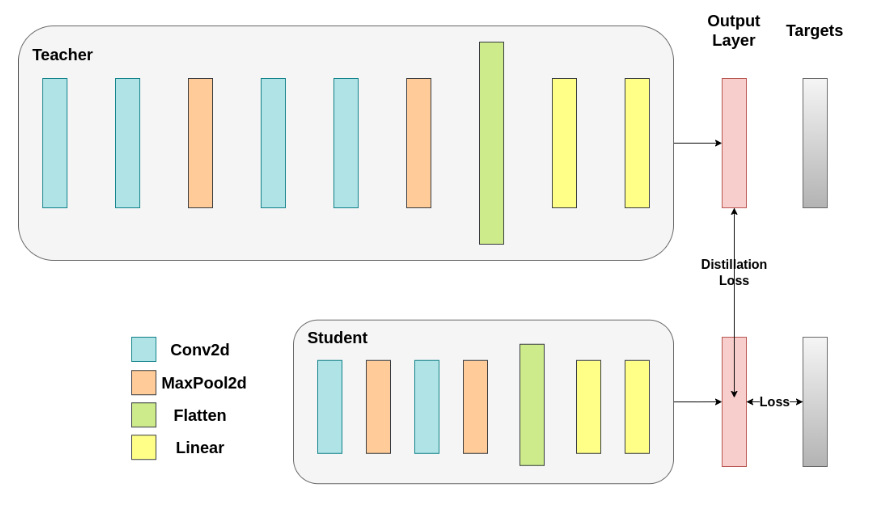

Distillation loss is calculated from the logits of the networks. It only returns gradients to the student

In [22]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval() # teacher set to evaluation mode
    student.train() # student set to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)
            
            # Forward pass with the student model
            student_logits = student(inputs)
            soft_targets = nn.functional.softmax(teacher_logits/T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits/T, dim=-1)
            
            # Calculate the soft targets loss.
            soft_target_loss = -torch.sum(soft_targets*soft_prob)/soft_prob.size()[0] * (T**2)
            
            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight*soft_target_loss + ce_loss_weight*label_loss

            loss.backward()
            optimizer.step()

            running_loss+=loss.item()

        print(f'Epoch: {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')


In [23]:
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, T=5, soft_target_loss_weight=0.5, ce_loss_weight=0.5, device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch: 1/10, Loss: 23.18022297715287
Epoch: 2/10, Loss: 20.165604457221068
Epoch: 3/10, Loss: 18.967455837122923
Epoch: 4/10, Loss: 18.174926940742356
Epoch: 5/10, Loss: 17.606590414900914
Epoch: 6/10, Loss: 17.106845543512602
Epoch: 7/10, Loss: 16.713845823731873
Epoch: 8/10, Loss: 16.389262526236532
Epoch: 9/10, Loss: 16.126640995445154
Epoch: 10/10, Loss: 15.887144800952024
Test Accuracy: 70.58%
Teacher accuracy: 74.12%
Student accuracy without teacher: 70.35%
Student accuracy with CE + KD: 70.58%


## Cosine loss minimization run

Let’s try including an objective for the student, but now let’s focus on their hidden states rather than their output layers. Our goal is to convey information from the teacher’s representation to the student by including a naive loss function, whose minimization implies that the flattened vectors that are subsequently passed to the classifiers have become more similar as the loss decreases. Of course, the teacher does not update its weights, so the minimization depends only on the student’s weights. The rationale behind this method is that we are operating under the assumption that the teacher model has a better internal representation that is unlikely to be achieved by the student without external intervention, therefore we artificially push the student to mimic the internal representation of the teacher. We will be using the `CosineEmbeddingLoss`.

When we applied distillation to the output layer we mentioned that both networks have the same number of neurons, equal to the number of classes. However, this is not the case for the layer following our convolutional layers. Here, the teacher has more neurons than the student after the flattening of the final convolutional layer. Our loss function accepts two vectors of equal dimensionality as inputs, therefore we need to somehow match them. We will solve this by including an average pooling layer after the teacher’s convolutional layer to reduce its dimensionality to match that of the student.

In [24]:
class ModifiedDeepNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output, 2)
        return x, flattened_conv_output_after_pooling


# Create a similar student class where we return a tuple. We do not apply pooling after flattening.
class ModifiedLightNNCosine(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedLightNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep = ModifiedDeepNNCosine(num_classes=10).to(device)
modified_nn_deep.load_state_dict(nn_deep.state_dict())

# Once again ensure the norm of the first layer is the same for both networks
print("Norm of 1st layer for deep_nn:", torch.norm(nn_deep.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(modified_nn_deep.features[0].weight).item())

# Initialize a modified lightweight network with the same seed as our other lightweight instances. This will be trained from scratch to examine the effectiveness of cosine loss minimization.
torch.manual_seed(42)
modified_nn_light = ModifiedLightNNCosine(num_classes=10).to(device)
print("Norm of 1st layer:", torch.norm(modified_nn_light.features[0].weight).item())


Norm of 1st layer for deep_nn: 7.512556076049805
Norm of 1st layer for modified_deep_nn: 7.512556076049805
Norm of 1st layer: 2.327361822128296


In [25]:
sample_input = torch.randn(128, 3, 32, 32).to(device)

logits, hidden_representation = modified_nn_light(sample_input)
# Print the shapes of the tensors
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

logits, hidden_representation = modified_nn_deep(sample_input)
# Print the shapes of the tensors
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


In our case, hidden_representation_size is 1024. This is the flattened feature map of the final convolutional layer of the student and as you can see, it is the input for its classifier. It is 1024 for the teacher too, because we made it so with avg_pool1d from 2048. The loss applied here only affects the weights of the student prior to the loss calculation. In other words, it does not affect the classifier of the student. The modified training loop is the following:

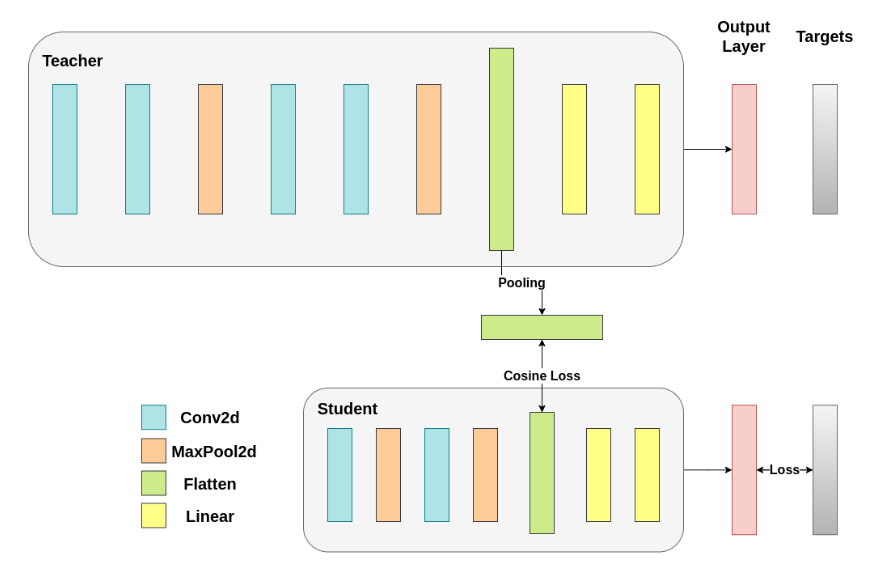

In Cosine Loss minimization, we want to maximize the cosine similarity of the two representations by returning gradients to the studen

In [26]:
def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr = learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval() # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass with the teacher model and keep only the hidden representation
            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)

            # Forward pass with the student model
            student_logits, student_hidden_representation = student(inputs)

            # Calculate the cosine loss. Target is a vector of ones. From the loss formula above we can see that is the case where loss minimization leads to cosine similarity increase.
            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))
            
            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)
            
             # Weighted sum of the two losses
            loss = hidden_rep_loss_weight*hidden_rep_loss + ce_loss_weight*label_loss
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [27]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device),labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted==labels).sum().item()

        accuracy = 100*correct/total

        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

In [28]:
# Train and test the lightweight network with cross entropy loss
train_cosine_loss(teacher=modified_nn_deep, student=modified_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.3, ce_loss_weight=0.7, device=device)
test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light, test_loader, device)

Epoch 1/10, Loss: 1.2627831920028647
Epoch 2/10, Loss: 1.0400086549846717
Epoch 3/10, Loss: 0.9456139305973297
Epoch 4/10, Loss: 0.8779470185794489
Epoch 5/10, Loss: 0.8258609297635305
Epoch 6/10, Loss: 0.785805763643416
Epoch 7/10, Loss: 0.750526871217791
Epoch 8/10, Loss: 0.7173309219462792
Epoch 9/10, Loss: 0.6819700783171008
Epoch 10/10, Loss: 0.6595188589657054
Test Accuracy: 70.74%


## Intermediate regressor run

Our naive minimization does not guarantee better results for several reasons, one being the dimensionality of the vectors. Cosine similarity generally works better than Euclidean distance for vectors of higher dimensionality, but we were dealing with vectors with 1024 components each, so it is much harder to extract meaningful similarities. Furthermore, pushing towards a match of the hidden representation of the teacher and the student is not supported by theory. There are no good reasons why we should be aiming for a 1:1 match of these vectors. We will provide a final example of training intervention by including an extra network called regressor. The objective is to first extract the feature map of the teacher after a convolutional layer, then extract a feature map of the student after a convolutional layer, and finally try to match these maps. However, this time, we will introduce a regressor between the networks to facilitate the matching process. The regressor will be trainable and ideally will do a better job than our naive cosine loss minimization scheme. Its main job is to match the dimensionality of these feature maps so that we can properly define a loss function between the teacher and the student. Defining such a loss function provides a teaching “path,” which is basically a flow to back-propagate gradients that will change the student’s weights. Focusing on the output of the convolutional layers right before each classifier for our original networks, we have the following shapes:

In [29]:
# Pass the sample input only from the convolutional feature extractor
convolutional_fe_output_student = nn_light.features(sample_input)
convolutional_fe_output_teacher = nn_deep.features(sample_input)

print("Student's feature extractor output shape: ", convolutional_fe_output_student.shape)
print("Teacher's feature extractor output shape: ", convolutional_fe_output_teacher.shape)

Student's feature extractor output shape:  torch.Size([128, 16, 8, 8])
Teacher's feature extractor output shape:  torch.Size([128, 32, 8, 8])


We have 32 filters for the teacher and 16 filters for the student. We will include a trainable layer that converts the feature map of the student to the shape of the feature map of the teacher. In practice, we modify the lightweight class to return the hidden state after an intermediate regressor that matches the sizes of the convolutional feature maps and the teacher class to return the output of the final convolutional layer without pooling or flattening.

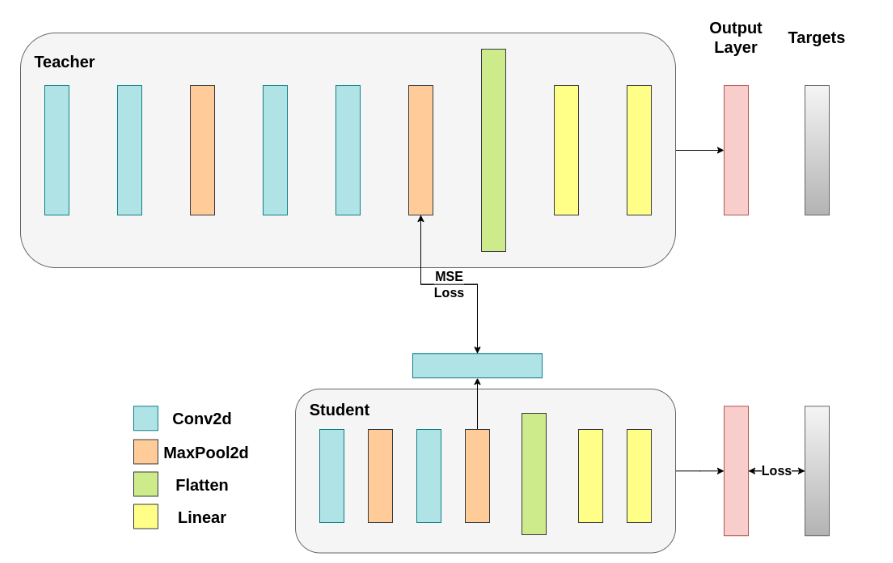



In [30]:
class ModifiedDeepNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )
        
    
    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map
    
class ModifiedLightNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x, regressor_output
    


In [32]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr = learning_rate)
    
    teacher.to(device)
    student.to(device)
    
    teacher.eval() # Teacher set to evaluation mode
    student.train() # Student to train mode
    
    for epoch in range(epochs):
        running_loss = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Again ignore teacher logits
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)
            
            # Forward pass with the student model
            student_logits, regressor_feature_map = student(inputs)
            
            # Calculate the loss
            hidden_rep_loss = mse_loss(teacher_feature_map, regressor_feature_map)
            
            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)
            
            # Weighted sum of the two losses
            loss = feature_map_weight*hidden_rep_loss + ce_loss_weight*label_loss

            loss.backward()
            optimizer.step()

            running_loss+=loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        
        
        

In [36]:
torch.manual_seed(42)
# Initialize a ModifiedLightNNRegressor
modified_nn_light_reg = ModifiedLightNNRegressor(num_classes=10).to(device)

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep_reg = ModifiedDeepNNRegressor(num_classes=10).to(device)
modified_nn_deep_reg.load_state_dict(nn_deep.state_dict())

train_mse_loss(modified_nn_deep_reg, modified_nn_light_reg, train_loader, 10, 0.001, 0.7, 0.3, device)
test_accuracy_light_ce_and_mse_loss = test_multiple_outputs(modified_nn_light_reg, test_loader, device)


Epoch 1/10, Loss: 2.46435131258367
Epoch 2/10, Loss: 1.8623932859171992
Epoch 3/10, Loss: 1.6857644200629895
Epoch 4/10, Loss: 1.5791623287493615
Epoch 5/10, Loss: 1.5173613430593935
Epoch 6/10, Loss: 1.4733884197366818
Epoch 7/10, Loss: 1.4377737734323877
Epoch 8/10, Loss: 1.4061846132473568
Epoch 9/10, Loss: 1.3794113617114094
Epoch 10/10, Loss: 1.3560561399020807
Test Accuracy: 71.29%


In [37]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE + CosineLoss: {test_accuracy_light_ce_and_cosine_loss:.2f}%")
print(f"Student accuracy with CE + RegressorMSE: {test_accuracy_light_ce_and_mse_loss:.2f}%")


Teacher accuracy: 74.12%
Student accuracy without teacher: 70.35%
Student accuracy with CE + KD: 70.58%
Student accuracy with CE + CosineLoss: 70.74%
Student accuracy with CE + RegressorMSE: 71.29%
